# Wildfire Detection DS420
### Authors: Aj Botticelli & Yusuke Satani
### Date: Spring 2023
### Goal: Using satellite image data from Kaggle (from the Canadian Govt), predict wildfire occurances in a model integrated with spark for real-time parsing
Based from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
and https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

## Imports

In [62]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

from PIL import ImageFile

## Preproccessing

In [63]:
pathTrain = "../input/wildfire-prediction-dataset/train"
pathVal = "../input/wildfire-prediction-dataset/valid"
pathTest = "../input/wildfire-prediction-dataset/test"

In [64]:
trainDatagen = ImageDataGenerator(rescale=1./255)
testDatagen = ImageDataGenerator(rescale=1./255)
validationDatagen = ImageDataGenerator(rescale=1./255)

In [65]:
#Target size chosen arbitrarily along with batch size
trainIter = trainDatagen.flow_from_directory(
    pathTrain,
    target_size=(256, 256),
    batch_size=16
)

Found 30250 images belonging to 2 classes.


In [66]:
#the elements in each category
from collections import Counter
counter = Counter(trainIter.classes)
print(counter.items())

dict_items([(0, 14500), (1, 15750)])


In [67]:
testIter = testDatagen.flow_from_directory(
    pathTest,
    target_size=(256, 256),
    batch_size=16
)

Found 6300 images belonging to 2 classes.


In [68]:
counter = Counter(testIter.classes)
print(counter.items())

dict_items([(0, 2820), (1, 3480)])


In [69]:
validIter = validationDatagen.flow_from_directory(
    pathVal,
    target_size=(256, 256),
    batch_size=16
)

Found 6300 images belonging to 2 classes.


In [70]:
counter = Counter(validIter.classes)
print(counter.items())

dict_items([(0, 2820), (1, 3480)])


In [71]:
trainIter.reset() 

batchX, batchy = trainIter.next()
print("Batch shape of X = " + str(batchX.shape) + ", Xmin = "+str(batchX.min()) + ", Xmax = "+str(batchX.max()))
print("Batch shape of Y = " + str(batchy.shape) + ", ymin = "+str(batchy.min()) + ", ymax = "+str(batchy.max()))

Batch shape of X = (16, 256, 256, 3), Xmin = 0.0, Xmax = 1.0
Batch shape of Y = (16, 2), ymin = 0.0, ymax = 1.0


In [72]:
print(trainIter.class_indices)

{'nowildfire': 0, 'wildfire': 1}


## Modeling
-Using first a simple self made CNN

-Then using a better CNN following AlexNet structure

In [73]:
# Dimensions of our images.
img_width, img_height = 256, 256 
input_shape = (img_width, img_height, 3) # each image has 3 channels

# Epochs
epochsAmt = 10

# Number of images to read every iteration 
batch_size = 64

# Total number of images for training and testing
train_num = 30250 
test_num = 6300 
valid_num = 6300 

# Total number of steps in each epoch
train_steps = train_num // batch_size # integer division
test_steps  = test_num  // batch_size 

# Total number of classes
num_classes = 2


### Base CNN

In [74]:
model = keras.Sequential(name = 'Wildfire-CNN')

model.add(layers.Conv2D(8, kernel_size = (3,3),activation = 'relu', input_shape = input_shape))

model.add(layers.Conv2D(16, kernel_size = (3,3),activation = 'relu'))

model.add(layers.MaxPooling2D(pool_size = (2,2)))

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(32,activation = 'relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(2,activation = 'softmax'))

model.summary()

Model: "Wildfire-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 conv2d_3 (Conv2D)           (None, 252, 252, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 126, 126, 16)      0         
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                8128544   
                                                      

In [75]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [76]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = history = model.fit(trainIter,
                    batch_size=batch_size,
                    epochs=epochsAmt,
                    validation_data=(validIter),
                    steps_per_epoch = train_steps,
                    validation_steps = test_steps)

Epoch 1/10
472/472 [==============================] - 323s 682ms/step - loss: 0.5143 - accuracy: 0.8325 - val_loss: 0.2265 - val_accuracy: 0.9241
Epoch 2/10
472/472 [==============================] - 320s 677ms/step - loss: 0.3038 - accuracy: 0.8844 - val_loss: 0.2221 - val_accuracy: 0.9241
Epoch 3/10
472/472 [==============================] - 318s 675ms/step - loss: 0.3034 - accuracy: 0.8852 - val_loss: 0.1774 - val_accuracy: 0.9388
Epoch 4/10
472/472 [==============================] - 320s 678ms/step - loss: 0.2771 - accuracy: 0.8913 - val_loss: 0.2040 - val_accuracy: 0.9209
Epoch 5/10
472/472 [==============================] - 314s 664ms/step - loss: 0.2638 - accuracy: 0.8982 - val_loss: 0.2595 - val_accuracy: 0.9196
Epoch 6/10
472/472 [==============================] - 313s 664ms/step - loss: 0.2430 - accuracy: 0.9068 - val_loss: 0.1693 - val_accuracy: 0.9375
Epoch 7/10
472/472 [==============================] - 313s 663ms/step - loss: 0.2404 - accuracy: 0.9073 - val_loss: 0.1888 -

In [77]:
result = model.evaluate(testIter)

394/394 [==============================] - 79s 201ms/step - loss: 0.1910 - accuracy: 0.9505


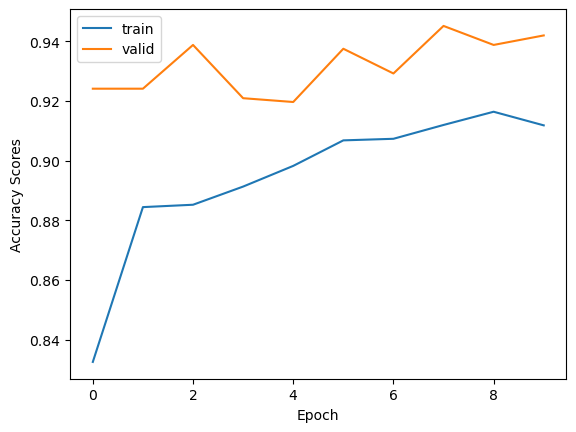

In [78]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy Scores')

plt.show()

In [79]:
y_pred = model.predict(trainIter)

1891/1891 [==============================] - 344s 182ms/step


In [80]:
len(y_pred)

30250

In [81]:
testIter.reset() 
images, labels =  testIter.next()


images.shape

(16, 256, 256, 3)

In [82]:
labels.shape

(16, 2)

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

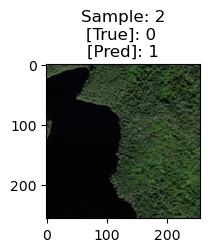

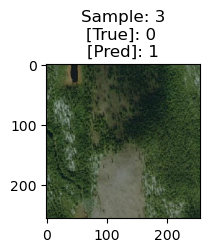

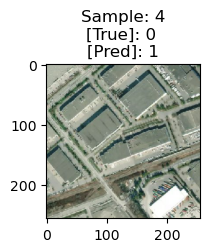

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

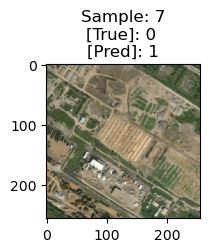

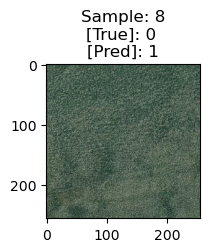

<Figure size 200x200 with 0 Axes>

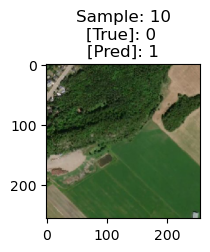

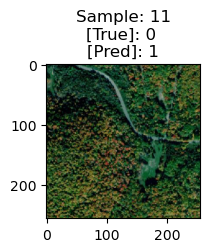

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

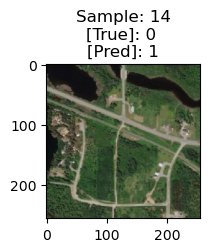

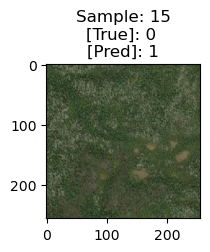

In [83]:
# Plot the image/prediction/fact
for idx, img in enumerate(images):
    plt.figure(figsize = (2, 2))
    pred_label=str(y_pred[idx].argmax())
    true_label=str(pred.argmax())
    if(pred_label!= true_label):
        plt.title('Sample: '+str(idx) + "\n[True]: "+true_label + " \n[Pred]: "+ pred_label)
        plt.imshow(img)
        plt.show()


## Tasks to Complete
### EDA:
-Show a picture
-Show distribution of classes
### Modeling:
-CNN(AlexNet)

-ImageNet Pretrained Model
### Visualization
-Show a few pictures with model + predicted label + true label
### Extra
-Consider Exporting the Model